In [1]:
import xml.etree.ElementTree as ET

def normalize_bbox(bbox, width, height, scale=1000):
     return [
         int(scale * (bbox[0] / width)),
         int(scale * (bbox[1] / height)),
         int(scale * (bbox[2] / width)),
         int(scale * (bbox[3] / height)),
     ]

def unnormalize_bbox(bbox, width, height, scale=1000):
    return [
        int((bbox[0] / scale) * width),
        int((bbox[1] / scale) * height),
        int((bbox[2] / scale) * width),
        int((bbox[3] / scale) * height),
    ]

def load_and_process_alto(alto_file):
    """
    Loads and processes an ALTO file, returning two lists:
        tokens: a list of strings, where each string is the content of a <String> element
        bboxes: a list of lists of integers, where each inner list represents the bounding box
                of the corresponding token in the tokens list. The format is [X1, Y1, X2, Y2]
    """
    tokens = []
    bboxes = []
    page_margins = []
    tree = ET.parse(alto_file)
    root = tree.getroot()
    # get xlmns from alto file
    xlmns = root.tag.split('}')[0] + '}'
    # Find all <Page> elements
    for page in root.findall(".//"+xlmns+"Page"):
        # Extract page dimensions
        page_width = int(page.attrib["WIDTH"])
        page_height = int(page.attrib["HEIGHT"])

        # Find all <TextLine> elements
        for textline in page.findall(".//"+xlmns+"TextLine"):
            for string in textline.findall(".//"+xlmns+"String"):
                # Extract token text and bounding box coordinates
                content = string.attrib["CONTENT"]
                h = int(string.attrib["HEIGHT"])
                w = int(string.attrib["WIDTH"])
                vpos = int(string.attrib["VPOS"])
                hpos = int(string.attrib["HPOS"])
                x1, y1 = hpos, vpos
                x2, y2 = x1 + w, y1 + h

                tokens.append(content)
                bboxes.append([x1, y1, x2, y2])

    return tokens, bboxes

In [2]:
def overlap(box1, box2):
  """
  This function computes the area of overlap between two bounding boxes.

  Args:
      box1: A list containing the coordinates of the first bounding box (xmin, ymin, xmax, ymax)
      box2: A list containing the coordinates of the second bounding box (xmin, ymin, xmax, ymax)

  Returns:
      The percentage [0.0-1.0] of the area of the first bounding box that is overlapped by the second bounding box.
  """

  assert box1[0] <= box1[2]
  assert box1[1] <= box1[3]
  assert box2[0] <= box2[2]
  assert box2[1] <= box2[3]

  if box1[0] == box1[2] or box1[1] == box1[3] or box2[0] == box2[2] or box2[1] == box2[3]:
      return 0.0

  # determine the coordinates of the intersection rectangle
  x_left = max(box1[0], box2[0])
  y_top = max(box1[1], box2[1])
  x_right = min(box1[2], box2[2])
  y_bottom = min(box1[3], box2[3])

  if x_right < x_left or y_bottom < y_top:
      return 0.0

  # The intersection of two axis-aligned bounding boxes is always an
  # axis-aligned bounding box
  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  # compute the area of both AABBs
  bb1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = intersection_area / bb1_area
  assert iou >= 0.0
  assert iou <= 1.0
  return iou


def is_inside(box1, box2):
  """
  This function checks if box1 is inside box2.

  Args:
      box1: A list containing the coordinates of the first bounding box (xmin, ymin, xmax, ymax)
      box2: A list containing the coordinates of the second bounding box (xmin, ymin, xmax, ymax)

  Returns:
      True if box1 is inside box2, False otherwise.
  """
  x_left1, y_top1, x_right1, y_bottom1 = box1
  x_left2, y_top2, x_right2, y_bottom2 = box2
  return x_left1 >= x_left2 and y_top1 >= y_top2 and x_right1 <= x_right2 and y_bottom1 <= y_bottom2

In [3]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("data")
DATASET = DATA_DIR / "VHA"
DATASET_ALTO = DATASET / "alto"
DATASET_IMAGES = DATASET / "images"
TEST_FILE_ALTO = DATASET_ALTO / "1.xml"
TEST_FILE_IMAGE = DATASET_IMAGES / "1.jpg"
DATASET_CSV = list(DATASET.glob("*.csv"))[0]
dataset = pd.read_csv(DATASET_CSV)
# select rows where poly not Nan
dataset.head()

,annotation_id,annotator,bbox,created_at,id,label,lead_time,ocr,poly,transcription,updated_at
0,3535,21,"[{""x"":9.037937301226734,""y"":5.105633802816902,...",2024-04-17T17:24:34.224433Z,60188,"[{""x"":9.037937301226734,""y"":5.105633802816902,...",7898.954,/data/upload/14/8634cacb-1.jpg,NaN,"[""Příjmení a jméno"",""Petr Efimov"",""Hodnost a p...",2024-04-24T14:29:08.202063Z
1,3536,22,"[{""x"":5.812827870040286,""y"":6.199460916442049,...",2024-04-17T22:27:27.896988Z,60189,"[{""x"":5.812827870040286,""y"":6.199460916442049,...",3218.212,/data/upload/14/b53d630f-2.jpg,NaN,"[""Příjmení a jméno"",""Ivan Josefovič Tskorostin...",2024-04-24T14:29:03.211568Z
2,3786,23,"[{""x"":6.44465698634901,""y"":5.840071877807719,""...",2024-04-24T13:51:49.487793Z,60190,"[{""x"":6.44465698634901,""y"":5.840071877807719,""...",124.145,/data/upload/14/74ac1cc0-3.jpg,NaN,"[""Příjmení a jméno"",""Hodnost a pluk"",""Datum a ...",2024-04-24T13:51:49.487799Z
3,3792,23,"[{""x"":6.933212176283508,""y"":5.28169014084507,""...",2024-04-24T13:55:04.214951Z,60191,"[{""x"":6.933212176283508,""y"":5.28169014084507,""...",146.150,/data/upload/14/20ceb832-4.jpg,NaN,"[""Příjmení a jméno"",""Hodnost a pluk"",""Datum a ...",2024-04-24T13:55:04.214963Z
4,3793,23,"[{""x"":7.304634257155838,""y"":6.338028169014084,...",2024-04-24T13:55:47.019083Z,60192,"[{""x"":7.304634257155838,""y"":6.338028169014084,...",33.555,/data/upload/14/50ae42e5-5.jpg,NaN,"[""Příjmení a jméno"",""Hodnost a pluk"",""Datum a ...",2024-04-24T13:55:47.019089Z


In [4]:
dataset["file"] = dataset["ocr"].apply(lambda x: x.rsplit("-")[-1])
dataset.head()

,annotation_id,annotator,bbox,created_at,id,label,lead_time,ocr,poly,transcription,updated_at,file
0,3535,21,"[{""x"":9.037937301226734,""y"":5.105633802816902,...",2024-04-17T17:24:34.224433Z,60188,"[{""x"":9.037937301226734,""y"":5.105633802816902,...",7898.954,/data/upload/14/8634cacb-1.jpg,NaN,"[""Příjmení a jméno"",""Petr Efimov"",""Hodnost a p...",2024-04-24T14:29:08.202063Z,1.jpg
1,3536,22,"[{""x"":5.812827870040286,""y"":6.199460916442049,...",2024-04-17T22:27:27.896988Z,60189,"[{""x"":5.812827870040286,""y"":6.199460916442049,...",3218.212,/data/upload/14/b53d630f-2.jpg,NaN,"[""Příjmení a jméno"",""Ivan Josefovič Tskorostin...",2024-04-24T14:29:03.211568Z,2.jpg
2,3786,23,"[{""x"":6.44465698634901,""y"":5.840071877807719,""...",2024-04-24T13:51:49.487793Z,60190,"[{""x"":6.44465698634901,""y"":5.840071877807719,""...",124.145,/data/upload/14/74ac1cc0-3.jpg,NaN,"[""Příjmení a jméno"",""Hodnost a pluk"",""Datum a ...",2024-04-24T13:51:49.487799Z,3.jpg
3,3792,23,"[{""x"":6.933212176283508,""y"":5.28169014084507,""...",2024-04-24T13:55:04.214951Z,60191,"[{""x"":6.933212176283508,""y"":5.28169014084507,""...",146.150,/data/upload/14/20ceb832-4.jpg,NaN,"[""Příjmení a jméno"",""Hodnost a pluk"",""Datum a ...",2024-04-24T13:55:04.214963Z,4.jpg
4,3793,23,"[{""x"":7.304634257155838,""y"":6.338028169014084,...",2024-04-24T13:55:47.019083Z,60192,"[{""x"":7.304634257155838,""y"":6.338028169014084,...",33.555,/data/upload/14/50ae42e5-5.jpg,NaN,"[""Příjmení a jméno"",""Hodnost a pluk"",""Datum a ...",2024-04-24T13:55:47.019089Z,5.jpg


### Testing bbox loading and normalization.

Tokens: ['Přijmení', 'a', 'jméno', 'A', 'Petr', 'příslušnost', 'polit.', 'okres,', 'země', 'Efimov', 'pěšák', 'ruský', 'p.', 'pl.', '502.', 'Datum', 'a', 'místo', 'narození', '1892', '(polit.', 'okres,', 'země)', 'Suchaja', 'Poljana', 'gub.', 'Kursk,', 'Rusko', 'tamtéž', 'Hodnost', 'a', 'pluk', 'Datum', 'pohřbu', '21.', 'VI.', '1918', 'táborová', 'nem', 'Osot', 'kom.', 'Vesrprém,', 'Uhry', '23.', 'VI.', '1918', 'Označení', 'hřbitova', 'a', 'místo', 'táborový', '(polit.', 'okres,', 'země)', 'Esot,', 'kom.', 'Veszprém', 'Uhry', 'Datum', 'a', 'místo', 'úmrtí', '(polit.', 'okres,', 'země)', 'Oddělení,', 'číslo', 'hrobu', 'Opsáno', 'podle', 'matr.', 'sešitu', 'zajatecké', 'nem', 'v', 'Csótu', 'za', 'měsíc', 'červen', '1918.', 'Úmrtní', 'kniha:', 'tom.', 'sol.', 'Jak.', '70', 'u', 'MNV.', '(skříň', 'č.', '2).', 'Tiskárna', 'MNO.', '—', '1163-36.']
Bounding boxes: [[100, 77, 267, 144], [272, 80, 293, 144], [309, 81, 432, 146], [459, 62, 495, 149], [942, 17, 1095, 108], [100, 601, 304, 645], [

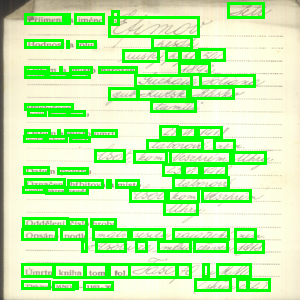

In [5]:
from PIL import Image, ImageDraw

tokens, bounding_boxes = load_and_process_alto(TEST_FILE_ALTO)
print("Tokens:", tokens)
print("Bounding boxes:", bounding_boxes)

image = Image.open(TEST_FILE_IMAGE)
orig_width, orig_height = image.size
new_width, new_height = 300, 300
image = image.resize((new_width, new_height))
draw = ImageDraw.Draw(image)

for bbox in bounding_boxes:
    x1, y1, x2, y2 = normalize_bbox(bbox, orig_width, orig_height)
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    draw.rectangle(unnormalize_bbox((x1,y1,x2,y2), new_width, new_height), None, (0, 255, 0), 3)

image

In [6]:
import json
def label_tokens(tokens, bboxes, annotation):
    """
    This function labels the tokens extracted from an ALTO file with the corresponding label from the datast based on the label bounding box.

    Args:
        tokens: A list of strings, where each string is the content of a <String> element in the ALTO file.
        bboxes: A list of lists of integers, where each inner list represents the bounding box of the corresponding token in the tokens list.
        annotation: A list of annotations for the image.
    Returns:
        3 lists, first containing the tokens, second containing the bounding boxes, and third containing the corresponding label.
    """
    labels = []
    for i, bbox in enumerate(bboxes):
        for label in annotation:
            l =  label["labels"][0]
            orig_w, orig_h = label["original_width"], label["original_height"]
            if label.get('points') is not None:
                x, y, x2, y2 = polygon_to_bbox(label["points"])
                x, y , x2, y2 = int(x * orig_w/100), int(y * orig_h/100), int(x2 * orig_w/100), int(y2 * orig_h/100)
                label_bbox = [x, y, x2, y2]
            elif label.get('x') is not None:
                x, y = label["x"], label["y"]
                w, h = label["width"], label["height"]
                x, y , w, h = int(x * orig_w/100), int(y * orig_h/100), int(w * orig_w/100), int(h * orig_h/100)
                label_bbox = [x, y, x + w, y + h]
            else:
                print(f"Unsuppoted label format. Skipping: {label}")
                continue
            
            if is_inside(bbox, label_bbox) or overlap(bbox, label_bbox) > 0.4:
                labels.append(l)
                break
        if len(labels) != i + 1:
            labels.append("background")

    return tokens, bboxes, labels

def polygon_to_bbox(points):
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    return [min(x), min(y), max(x), max(y)]

In [7]:
# row where Ekimof in transcription
dataset[dataset["transcription"].apply(lambda x: "Efimov" in x)]

,annotation_id,annotator,bbox,created_at,id,label,lead_time,ocr,poly,transcription,updated_at,file
0,3535,21,"[{""x"":9.037937301226734,""y"":5.105633802816902,...",2024-04-17T17:24:34.224433Z,60188,"[{""x"":9.037937301226734,""y"":5.105633802816902,...",7898.954,/data/upload/14/8634cacb-1.jpg,NaN,"[""Příjmení a jméno"",""Petr Efimov"",""Hodnost a p...",2024-04-24T14:29:08.202063Z,1.jpg


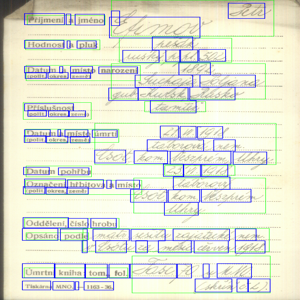

In [8]:
tokens, bounding_boxes = load_and_process_alto(TEST_FILE_ALTO)
annot = [json.loads(value) for value in dataset[dataset["file"] == TEST_FILE_IMAGE.name]["label"].values][0]
image = Image.open(TEST_FILE_IMAGE)
image_draw = ImageDraw.Draw(image)
for label in annot:
    x, y, w, h = label["x"], label["y"], label["width"], label["height"]
    orig_w = label["original_width"]
    orig_h = label["original_height"]
    x, y , w, h = int(x * orig_w/100), int(y * orig_h/100), int(w * orig_w/100), int(h * orig_h/100)
    label_bbox = [x, y, x + w, y + h]
    image_draw.rectangle((x, y, x + w, y + h), None, (0, 255, 0), 2)
for bbox in bounding_boxes:
    x1, y1, x2, y2 = bbox
    if x1 < 0:
        x1 = 0
    if y1 < 0:    
        y1 = 0
    image_draw.rectangle((x1, y1, x2, y2), None, (0, 0, 255), 3)
tokens, bounding_boxes, labels = label_tokens(tokens, bounding_boxes, annot)
assert len(tokens) == len(labels)
image.resize((300, 300))


### LABELs to NER TAGS to IDs conversion

In [9]:
label_names = ["background", "birth_date", "death_book", "death_date", "funeral_date", "grave_id", "grave_location", "information", "information_source", "key", "name", "nationality", "rank"]
label_to_ner = {"background": "O",
                "birth_date": "BDATE",
                "death_book": "DEATHBOOK",
                "death_date": "DEATHDATE",
                "funeral_date": "FUNERAL",
                "grave_id": "GRAVEID",
                "grave_location": "GRAVELOC",
                "information": "INFO",
                "information_source": "INFOSRC",
                "key": "KEY",
                "name": "NAME",
                "nationality": "NAT",
                "rank": "RANK"}
# create list of ner tags from label_to_ner.values() 
ner_tags = ["O"]
for label in set(label_to_ner.values()) - {"O"}:
    ner_tags.append("B-" + label)
    ner_tags.append("I-" + label)
ner_tags

ner2id = {ner: i for i, ner in enumerate(ner_tags)}
id2ner = {i: ner for i, ner in enumerate(ner_tags)}

def convert_labels_to_ner(labels, label_to_ner):
    """
    This function converts the labels to NER tags.
      From processing of the ALTO OCR we have tokens ordered correctly,
        so we can just convert the continuous label groups to NER tags with B- and I- marks respectively.

    Args:
        labels: A list of labels.
        label_to_ner: A dictionary mapping labels to NER tags.

    Returns:
        A list of NER tags from labels.
    """
    ner_tags = []
    prev_label = None
    for label in labels:
        if label == "background":
            ner_tags.append(label_to_ner[label])
        else:
            if prev_label == label:
                ner_tags.append(f"I-{label_to_ner[label]}")
            else:
                ner_tags.append(f"B-{label_to_ner[label]}")
        prev_label = label
    return ner_tags

ner_tags = convert_labels_to_ner(labels, label_to_ner)
assert len(tokens) == len(ner_tags)
for token, ner_tag in zip(tokens, ner_tags):
    print(f"{token} -> {ner_tag}")


Přijmení -> B-KEY
a -> I-KEY
jméno -> I-KEY
A -> B-NAME
Petr -> I-NAME
příslušnost -> B-KEY
polit. -> I-KEY
okres, -> I-KEY
země -> I-KEY
Efimov -> B-NAME
pěšák -> B-RANK
ruský -> I-RANK
p. -> I-RANK
pl. -> I-RANK
502. -> I-RANK
Datum -> B-KEY
a -> I-KEY
místo -> I-KEY
narození -> I-KEY
1892 -> B-BDATE
(polit. -> B-KEY
okres, -> I-KEY
země) -> I-KEY
Suchaja -> B-BDATE
Poljana -> I-BDATE
gub. -> I-BDATE
Kursk, -> I-BDATE
Rusko -> I-BDATE
tamtéž -> B-NAT
Hodnost -> B-KEY
a -> I-KEY
pluk -> I-KEY
Datum -> I-KEY
pohřbu -> I-KEY
21. -> B-DEATHDATE
VI. -> I-DEATHDATE
1918 -> I-DEATHDATE
táborová -> I-DEATHDATE
nem -> I-DEATHDATE
Osot -> I-DEATHDATE
kom. -> I-DEATHDATE
Vesrprém, -> I-DEATHDATE
Uhry -> I-DEATHDATE
23. -> B-FUNERAL
VI. -> I-FUNERAL
1918 -> I-FUNERAL
Označení -> B-KEY
hřbitova -> I-KEY
a -> I-KEY
místo -> I-KEY
táborový -> B-GRAVELOC
(polit. -> B-KEY
okres, -> I-KEY
země) -> I-KEY
Esot, -> B-GRAVELOC
kom. -> I-GRAVELOC
Veszprém -> I-GRAVELOC
Uhry -> I-GRAVELOC
Datum -> B-KEY
a -

In [10]:
from transformers import LayoutLMv2FeatureExtractor, LayoutXLMTokenizer

feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
tokenizer = LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base")

c:\Users\Fergons\miniconda3\envs\detectron\lib\site-packages\transformers\models\layoutlmv2\feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [11]:
import datasets
# define the dataset with features being the tokens, bboxes,  labels(ner tags), image

class VHA(datasets.DatasetBuilder):
    """
    A dataset builder for the VHA dataset. Combining the ALTO OCR data for each document image with the labels from the CSV file.
    Args:
        config: A `datasets.BuilderConfig` object.
        cache_dir: A string representing the cache directory to store the downloaded and processed data.
    """

    def _info(self):
        return datasets.DatasetInfo(
            description="",
            features=datasets.Features({
                "file_id": datasets.Value("string"),
                "tokens": datasets.Sequence(datasets.Value("string")),
                "bboxes": datasets.Sequence(datasets.Sequence(datasets.Value("int32"))),
                "labels": datasets.Sequence(datasets.Value("string")),
                "image": datasets.Value("string"),
                "alto": datasets.Value("string")
            })
        )

    def _split_generators(self, dl_manager):
        """Defines splits in the dataset (e.g., train, dev, test)."""
        urls = {
            "train": "", 
            "dev": ""
        }
        data_files = dl_manager.download_and_extract(urls)
        return [
            datasets.SplitGenerator(name=split_name, gen_kwargs={"data_file": data_files[split_name]})
            for split_name in self.config.split
        ]

    def _generate_examples(self, data_file):
        """Parses data from downloaded files into examples."""
        with open(data_file, "r", encoding="utf-8") as f:
            for line in f:
                # Parse each line based on your data format
                text, label = line.strip().split("\t")  # Example for tab-separated data
                yield {
                    "text": text,
                    "label": label
                }

# Define dataset configurations (optional)
class ConfigVHA(datasets.BuilderConfig):
    """Builder configuration options (e.g., version, features)."""

    name = "vha_config"
    version = "1.0.0"
    ignore_supervised_keys = False  # Set to True if features are not for supervised learning


def tokenize_and_expand_features(tokens, bounding_boxes, labels, tokenizer):
    """
    This function tokenizes the tokens and expands the labels to match the tokenization.

    Args:
        tokens: A list of tokens.
        bounding_boxes: A list of bounding boxes for each token.
        labels: A list of labels for each token.
        tokenizer: A tokenizer object to tokenize the tokens.

    Returns:
        A list of tokenized tokens, bounding boxes, and labels.
    """
    assert len(tokens) == len(bounding_boxes) == len(labels), f"The number of tokens, bounding boxes, and labels must match. {len(tokens)=} != {len(bounding_boxes)=} != {len(labels)=}"
    return tokenizer(tokens, boxes=bounding_boxes, word_labels=labels, padding=False, truncation=False)


def preprocess_data(examples, tokenizer=None, dataset_dir=None, image_dir=None, alto_dir=None, image_size=(224, 224)):
    """
    Original data for this dataset consists of just the images of documents.
    Those images were labeld using Label Studio and the output is stored in a CSV file.
    Annotated data is stored in the CSV file with the following important columns:
        - ocr: The name of the image file (weird)
        - transcription: The transcription of the image (if annotated with transcriptions, most of the time empty)
        - label: List of dictionaries where each contains annotation bounding box with it's label and original image size.
    Another important file is the ALTO file for each image, which contains the OCR data.
    The ALTO file is processed to extract tokens and bounding boxes for each token which is then labeled with the label from the CSV file.
    """
    assert dataset_dir is not None, "Please provide the dataset directory."
    assert image_dir is not None, "Please provide the image directory."
    assert alto_dir is not None, "Please provide the ALTO directory."
    assert tokenizer is not None, "Please provide a tokenizer."

    dataset_dir = Path(dataset_dir)
    alto_dir = Path(alto_dir)
    image_dir = Path(image_dir)
    # find the original image name 
    file_names = [example["ocr"].rsplit("-")[-1] for example in examples]
    for file in file_names:
        alto_file = alto_dir / file.replace(".jpg", ".xml")
        image_file = image_dir / file
        image = Image.open(image_file)
        orig_width, orig_height = image.size
        image = image.resize(image_size)
        image = image.convert("RGB")
        tokens, bounding_boxes = load_and_process_alto(alto_file) # extracting tokens and bounding boxes from ALTO file
        annot = [json.loads(value) for value in dataset[dataset["file"] == file]["label"].values][0] # extracting annotations from CSV file
        tokens, bounding_boxes, labels = label_tokens(tokens, bounding_boxes, annot) # labeling tokens with annotations
        bounding_boxes = [normalize_bbox(bbox, orig_width, orig_height) for bbox in bounding_boxes] # normalizing bounding boxes
        ner_tags = convert_labels_to_ner(labels, label_to_ner) # converting labels to NER tags
        yield {"tokens": tokens, "bboxes": bounding_boxes, "labels": ner_tags, "image": image}



from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

In [12]:
train_dataset = datasets.Dataset.from_generator(preprocess_data, gen_kwargs={"examples": list(train_df.to_dict("records")), "dataset_dir": DATASET, "image_dir": DATASET_IMAGES, "alto_dir": DATASET_ALTO, "tokenizer": tokenizer, "image_size": (224, 224)})
test_dataset = datasets.Dataset.from_generator(preprocess_data, gen_kwargs={"examples": list(test_df.to_dict("records")), "dataset_dir": DATASET, "image_dir": DATASET_IMAGES, "alto_dir": DATASET_ALTO, "tokenizer": tokenizer, "image_size": (224, 224)})

In [19]:
from transformers import PreTrainedTokenizerBase
from transformers.file_utils import PaddingStrategy
from torch.utils.data import DataLoader
from dataclasses import dataclass
import torch

from typing import Optional, Union

@dataclass
class DataCollatorForTokenClassification:
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.
    
    Args:
        tokenizer (:class:`~transformers.PreTrainedTokenizer` or :class:`~transformers.PreTrainedTokenizerFast`):
            The tokenizer used for encoding the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.file_utils.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (:obj:`int`, `optional`, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
    """

    feature_extractor: LayoutLMv2FeatureExtractor
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100

    def __call__(self, features):
        # prepare image input
        image = self.feature_extractor([feature["image"] for feature in features], return_tensors="pt").pixel_values
        # prepare text input
        for feature in features:
            del feature["image"]

        batch = self.tokenizer(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt"
        )
        print(batch)
        batch["image"] = image
            
        return batch

data_collator = DataCollatorForTokenClassification(
    feature_extractor,
    tokenizer,
    pad_to_multiple_of=None,
    padding="max_length",
    max_length=512,
)



In [20]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
testloader = DataLoader(test_dataset, batch_size=16, collate_fn=data_collator)

In [15]:
from transformers import LayoutLMv2ForTokenClassification

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutxlm-base',
                                                         id2label=id2ner,
                                                         label2id=ner2id)

C:\Users\Fergons\AppData\Roaming\Python\Python38\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\Fergons\AppData\Roaming\Python\Python38\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutxlm-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from datasets import load_metric
import numpy as np

# Metrics
metric = load_metric("seqeval")
return_entity_level_metrics = True

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2ner[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2ner[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

C:\Users\Fergons\AppData\Local\Temp\ipykernel_8852\2756178445.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
c:\Users\Fergons\miniconda3\envs\detectron\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [17]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir="layoutxlm-finetuned-vha", # name of directory to store the checkpoints
    overwrite_output_dir=True,
    max_steps=1000, # we train for a maximum of 1,000 batches
    warmup_ratio=0.1, # we warmup a bit
    # fp16=True, # we use mixed precision (less memory consumption)
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    remove_unused_columns=False,
    push_to_hub=False, # we'd like to push our model to the hub during training
)

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

c:\Users\Fergons\miniconda3\envs\detectron\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
